In [7]:
import igl
import networkx as nx
import numpy as np
import meshplot as mp
import drawsvg as draw
import scipy.spatial.transform
import math

In [8]:
# Utils to create a graph from a mesh (just use the last function)


def is_adjacent(current_face: np.ndarray, face: np.ndarray) -> bool:
    is_adjacent = False
    common_vertices = np.intersect1d(current_face, face)
    if len(common_vertices) >=2:
        is_adjacent = True
    return is_adjacent


def add_edges_from_mesh(graph: nx.Graph, faces: np.ndarray) -> None:
    for current_face_id, current_face in enumerate(faces):
        for face_id, face in enumerate(faces):
            if is_adjacent(current_face, face) and current_face_id != face_id:
                graph.add_edge(current_face_id,face_id)


def add_nodes_from_mesh(graph: nx.Graph, faces: np.ndarray) -> None: 
    for face_id, face in enumerate(faces):
        graph.add_node(face_id) 


def graph_from_mesh(faces: np.ndarray) -> nx.Graph:
    graph = nx.Graph()
    add_nodes_from_mesh(graph, faces)
    add_edges_from_mesh(graph, faces)
    return graph

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-5.0, 8.0…

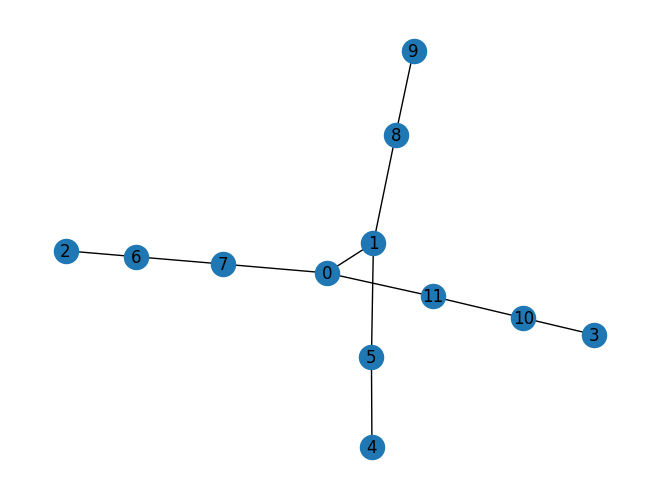

In [9]:
# Import a cube and create the graph

raw_vertices, raw_faces = igl.read_triangle_mesh("cube.stl")
vertices, faces = igl.remove_duplicates(raw_vertices, raw_faces, 0.00001)

graph = graph_from_mesh(faces)

cube_spanning_tree = nx.minimum_spanning_tree(graph, algorithm='prim')

p = mp.plot(vertices, faces, c=np.random.rand(*faces.shape))

nx.draw(cube_spanning_tree, with_labels = True)

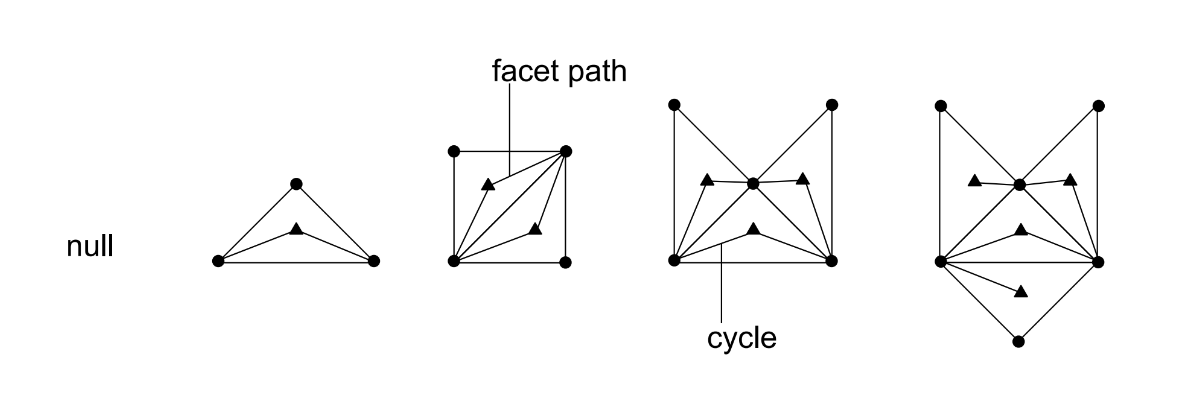

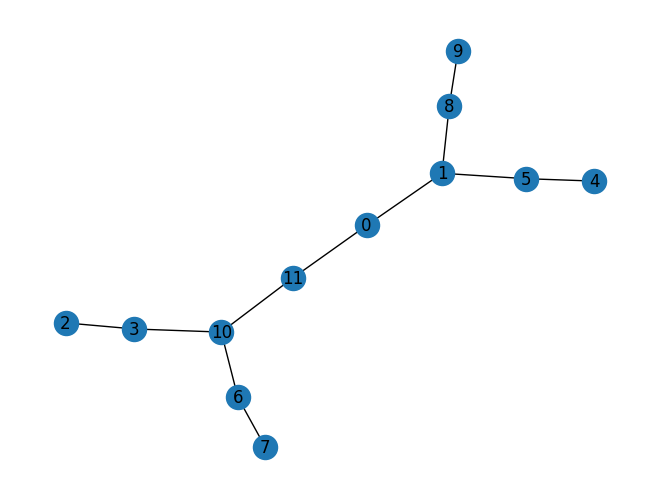

In [10]:
# Spanning Tree with just facet path type:

facet_path_spanning_tree = nx.Graph()

facet_path_spanning_tree.add_edge(4, 5)
facet_path_spanning_tree.add_edge(5, 1)
facet_path_spanning_tree.add_edge(9, 8)
facet_path_spanning_tree.add_edge(8, 1)
facet_path_spanning_tree.add_edge(1, 0)
facet_path_spanning_tree.add_edge(0, 11)
facet_path_spanning_tree.add_edge(11, 10)
facet_path_spanning_tree.add_edge(10, 6)
facet_path_spanning_tree.add_edge(10, 3)
facet_path_spanning_tree.add_edge(3, 2)
facet_path_spanning_tree.add_edge(6, 7)

nx.draw(facet_path_spanning_tree, with_labels = True)

In [24]:
def generate_facet_graph(spanning_tree: nx.Graph, faces: np.ndarray, verbose: bool = False) -> nx.Graph:

    tree_0 = spanning_tree.copy()
    tree_1 = spanning_tree.copy()
    
    level_array = np.zeros(len(faces))
    
    
    iteration_no = 1
    while tree_1.number_of_nodes() >= 1:
        for node_id in list(tree_0.nodes):
            if tree_0.degree[node_id] <= 1:
                tree_1.remove_node(node_id)
                level_array[node_id] = iteration_no
        tree_0 = tree_1.copy()
        iteration_no = iteration_no + 1

    if verbose:
        print("Level Array", level_array)
    
    facet_graph = nx.Graph()
    
    for even_iterator in range (2, int(max(level_array))+1, 2):
        for face_id in range (len(level_array)):
            if level_array[face_id] == even_iterator:
                neighbour_faces = list(spanning_tree.adj[face_id])
                for adj_face in neighbour_faces:
                    adj_neighbour_faces = list(spanning_tree.adj[adj_face])
                    if level_array[adj_face] == even_iterator - 1:
                        common_vertices = np.intersect1d(faces[face_id], faces[adj_face])
                        facet_graph.add_edge(face_id, "v" + str(common_vertices[0]))
                        facet_graph.add_edge(face_id, "v" + str(common_vertices[1]))
                        facet_graph.add_edge(adj_face, "v" + str(common_vertices[0]))
                        facet_graph.add_edge(adj_face, "v" + str(common_vertices[1]))
    
    for node in spanning_tree:
        if node not in facet_graph.nodes:
            neighbour_faces = list(spanning_tree.adj[node])
            assert len(neighbour_faces) == 1
            neighbour = neighbour_faces[0]
            assert level_array[neighbour] % 2 == 1
            common_vertices = np.intersect1d(faces[node], faces[neighbour])
            facet_graph.add_edge(node, "v" + str(common_vertices[0]))
            facet_graph.add_edge(node, "v" + str(common_vertices[1]))

    for face_id in range(len(faces) - 1):
        nei_nodes = list(spanning_tree.adj[face_id])
        for adj_face_id in nei_nodes:scope of variavles notebook
            if (nx.has_path(facet_graph, face_id, adj_face_id)) is False:
                common_vertices = np.intersect1d(faces[face_id], faces[adj_face_id])
    
                if facet_graph.has_edge(face_id, "v" + str(common_vertices[0])):
                    facet_graph.remove_edge(face_id, "v" + str(common_vertices[0]))
                else:
                    facet_graph.add_edge(face_id, "v" + str(common_vertices[0]))
                if facet_graph.has_edge(face_id, "v" + str(common_vertices[1])):
                    facet_graph.remove_edge(face_id, "v" + str(common_vertices[1]))
                else:
                    facet_graph.add_edge(face_id, "v" + str(common_vertices[1]))
    
                if facet_graph.has_edge(adj_face_id, "v" + str(common_vertices[0])):
                    facet_graph.remove_edge(adj_face_id, "v" + str(common_vertices[0]))
                else:
                    facet_graph.add_edge(adj_face_id, "v" + str(common_vertices[0]))
                if facet_graph.has_edge(adj_face_id, "v" + str(common_vertices[1])):
                    facet_graph.remove_edge(adj_face_id, "v" + str(common_vertices[1]))
                else:
                    facet_graph.add_edge(adj_face_id, "v" + str(common_vertices[1]))
            
    return facet_graph

Level Array [4. 3. 1. 2. 1. 2. 2. 1. 2. 1. 3. 4.]


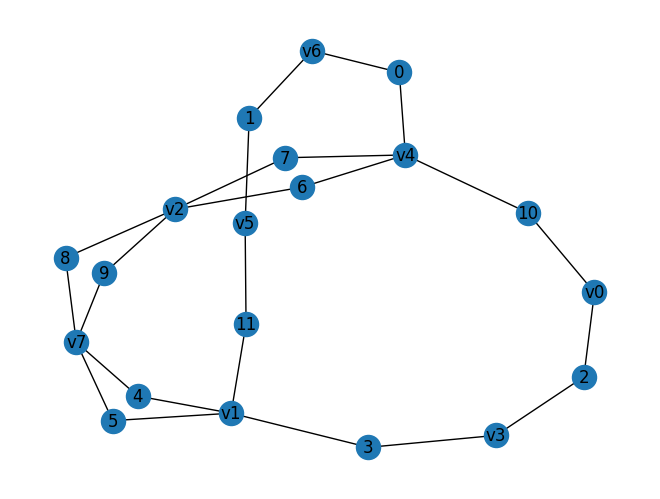

In [25]:
facet_graph = generate_facet_graph(facet_path_spanning_tree, faces, verbose=True)

nx.draw(facet_graph, with_labels = True)

In [14]:
eulerian_circuit = list(nx.eulerian_circuit(facet_graph))
eulerian_circuit

[(3, 'v1'),
 ('v1', 4),
 (4, 'v7'),
 ('v7', 9),
 (9, 'v2'),
 ('v2', 8),
 (8, 'v7'),
 ('v7', 5),
 (5, 'v1'),
 ('v1', 11),
 (11, 'v5'),
 ('v5', 1),
 (1, 'v6'),
 ('v6', 0),
 (0, 'v4'),
 ('v4', 7),
 (7, 'v2'),
 ('v2', 6),
 (6, 'v4'),
 ('v4', 10),
 (10, 'v0'),
 ('v0', 2),
 (2, 'v3'),
 ('v3', 3)]

In [37]:
# Utils to get rotation matices


def get_face_normal(vertices: np.ndarray, faces: np.ndarray, face_id: int) -> np.ndarray:
    face_normals = igl.per_face_normals(vertices, faces, np.ones((1, 3)))
    return face_normals[face_id]


def get_rotation_matrix(axis: np.ndarray, angle: np.float64) -> np.ndarray:
    return scipy.spatial.transform.Rotation.from_rotvec(axis/np.linalg.norm(axis) * angle).as_matrix()


def get_2d_projection(face_normal: np.ndarray) -> np.ndarray:
    xy_plane_normal = np.array([0, 0, 1])
    rotation_axis = np.cross(face_normal, xy_plane_normal)
    angle = np.arccos(np.clip(np.dot(xy_plane_normal, face_normal), -1.0, 1.0))

    discard_z_matrix = np.array([
        [1, 0, 0],
        [0, 1, 0]
    ])
    if np.linalg.norm(rotation_axis) == 0:
        return discard_z_matrix
    rotation_matrix = get_rotation_matrix(rotation_axis, angle)
    return discard_z_matrix.dot(rotation_matrix)


def test_2d_projection():
    v = np.array([[0.0,0.0,0.0], [0.0,0.0,1.0], [0.0,1.0,0.0]])
    f = np.array([[0,1,2], [0,1,2]])
    
    face_coordinates = [v[vertex_id] for vertex_id in f[0]]
    for i in range(3):
        face_coordinates[i] = get_2d_projection(get_face_normal(v, f, 0)).dot(face_coordinates[i])
    assert face_coordinates[0][0] == 0
    assert face_coordinates[0][1] == 0
    assert face_coordinates[1][0] == 1
    assert face_coordinates[1][1] == 0
    assert face_coordinates[2][0] == 0
    assert face_coordinates[2][1] == 1


test_2d_projection()

In [38]:
# Utils to translate triangle to origin


def tranlate_to_origin(face_coordinates, verbose = False):
    if verbose:
        print("Before Translation", face_coordinates)
    min_x = face_coordinates[0][0]
    min_vector = face_coordinates[0]
    for i in range(3):
        if face_coordinates[i][0] < min_x:
            min_x = face_coordinates[i][0]
            min_vector = face_coordinates[i]
    for i in range(3):
        face_coordinates[i] = face_coordinates[i] - min_vector
    if verbose:
        print("After Translation", face_coordinates)
    return face_coordinates


def test_translation():
    t = tranlate_to_origin([np.array([20., 18.]), np.array([-0.0, -2.]), np.array([20., -2.])], verbose=True) 
    assert t[0][0] == 20
    assert t[0][1] == 20
    assert t[1][0] == 0
    assert t[1][1] == 0
    assert t[2][0] == 20
    assert t[2][1] == 0


test_translation()

Before Translation [array([20., 18.]), array([-0., -2.]), array([20., -2.])]
After Translation [array([20., 20.]), array([0., 0.]), array([20.,  0.])]


In [57]:
def rotate_triangle_to_line(face_coordinates, common_vertex1, common_vertex2, verbose: bool = False):
    c1 = face_coordinates[common_vertex1][1] - face_coordinates[common_vertex2][1]
    c2 = face_coordinates[common_vertex1][0] - face_coordinates[common_vertex2][0]
    if c2 == 0:
        for i in range(3):
            face_coordinates[i] = np.array([
                    [0, 1],
                    [-1, 0]
                ]).dot(face_coordinates[i])
        if verbose:
            print("Rotate 90.0")
    else:
        rotation_matrix = get_rotation_matrix(np.array([0., 0., 1.]), - math.atan(c1/c2))
        discard_z_matrix = np.array([
            [1, 0, 0],
            [0, 1, 0]
        ])
        for i in range(3):
            face_coordinates[i] = np.delete(discard_z_matrix.dot(rotation_matrix), 2, 1).dot(face_coordinates[i])
        if verbose:
            print("Rotate", math.degrees(math.atan(c1/c2)))
        
    if face_coordinates[common_vertex1][0] > face_coordinates[common_vertex2][0]:
        for i in range(3):
            face_coordinates[i] = np.array([
                    [-1, 0],
                    [0, -1]
                ]).dot(face_coordinates[i])
        if verbose:
            print("Rotate 180.0")
    return face_coordinates


def test_rotation():
    r = rotate_triangle_to_line([np.array([.0, .0]), np.array([1.0, .0]), np.array([1, 1])] , 2, 0, verbose=True)
    epsilon = 10e-8
    assert r[0][0] == 0
    assert r[0][1] == 0
    assert abs(r[1][0] + math.sqrt(2) / 2) < epsilon
    assert r[1][1] - math.sqrt(2) / 2 < epsilon
    assert abs(r[2][0] + math.sqrt(2)) < epsilon 
    assert r[2][1] < epsilon


test_rotation()

Rotate 45.0
Rotate 180.0


In [108]:
def get_polygons_and_offsets() -> tuple():
    
    polygons = []
    offsets = [[0,0]]
    x_offset = 0
    y_offset = 0
    
    face_order = []
    vertex_order = []
    
    for first, second in eulerian_circuit:
        if "v" not in str(first):
            face_order.append(first)
        else:
            vertex_order.append(int(first[1:]))
    
    for n, face_index in enumerate(face_order):
        face_coordinates = [vertices[vertex_id] for vertex_id in faces[face_index]]
        for i in range(3):
            face_coordinates[i] = get_2d_projection(get_face_normal(vertices, faces, face_index)).dot(face_coordinates[i])
        v1 = None
        v2 = None
        for i, vertex_index in enumerate(faces[face_index]):
            if vertex_index == vertex_order[len(vertex_order) - 1 if n - 1 < 0 else n - 1]:
                v1 = i
            if vertex_index == vertex_order[n]:
                v2 = i
        polygons.append(tranlate_to_origin(rotate_triangle_to_line(face_coordinates, v1, v2)))
        for i in range(3):
            face_coordinates[i] = face_coordinates[i] + np.array([x_offset, y_offset])
        x_offset = face_coordinates[v2][0]
        y_offset = face_coordinates[v2][1]
        offsets.append([x_offset, y_offset])

    return polygons,  offsets


def draw_vertex_unfolding(polygons: list, offset: list) -> draw.Drawing:
    zoom = 5
    
    drawing = draw.Drawing((offsets[-1][0] + 100) * zoom, 1000, origin=(-50 * zoom, -500))
    for polygon in polygons:
        drawing.append(draw.Lines(*np.array(polygon).flatten() * zoom,
                       close=True, fill='#eeee00', stroke='#000', stroke_width=.1))
        
    for offset in offsets:
        drawing.append(draw.Circle(*np.array(offset) * zoom,
                       1 * zoom, fill='lime'))
    
    
    drawing.rasterize()
    return drawing

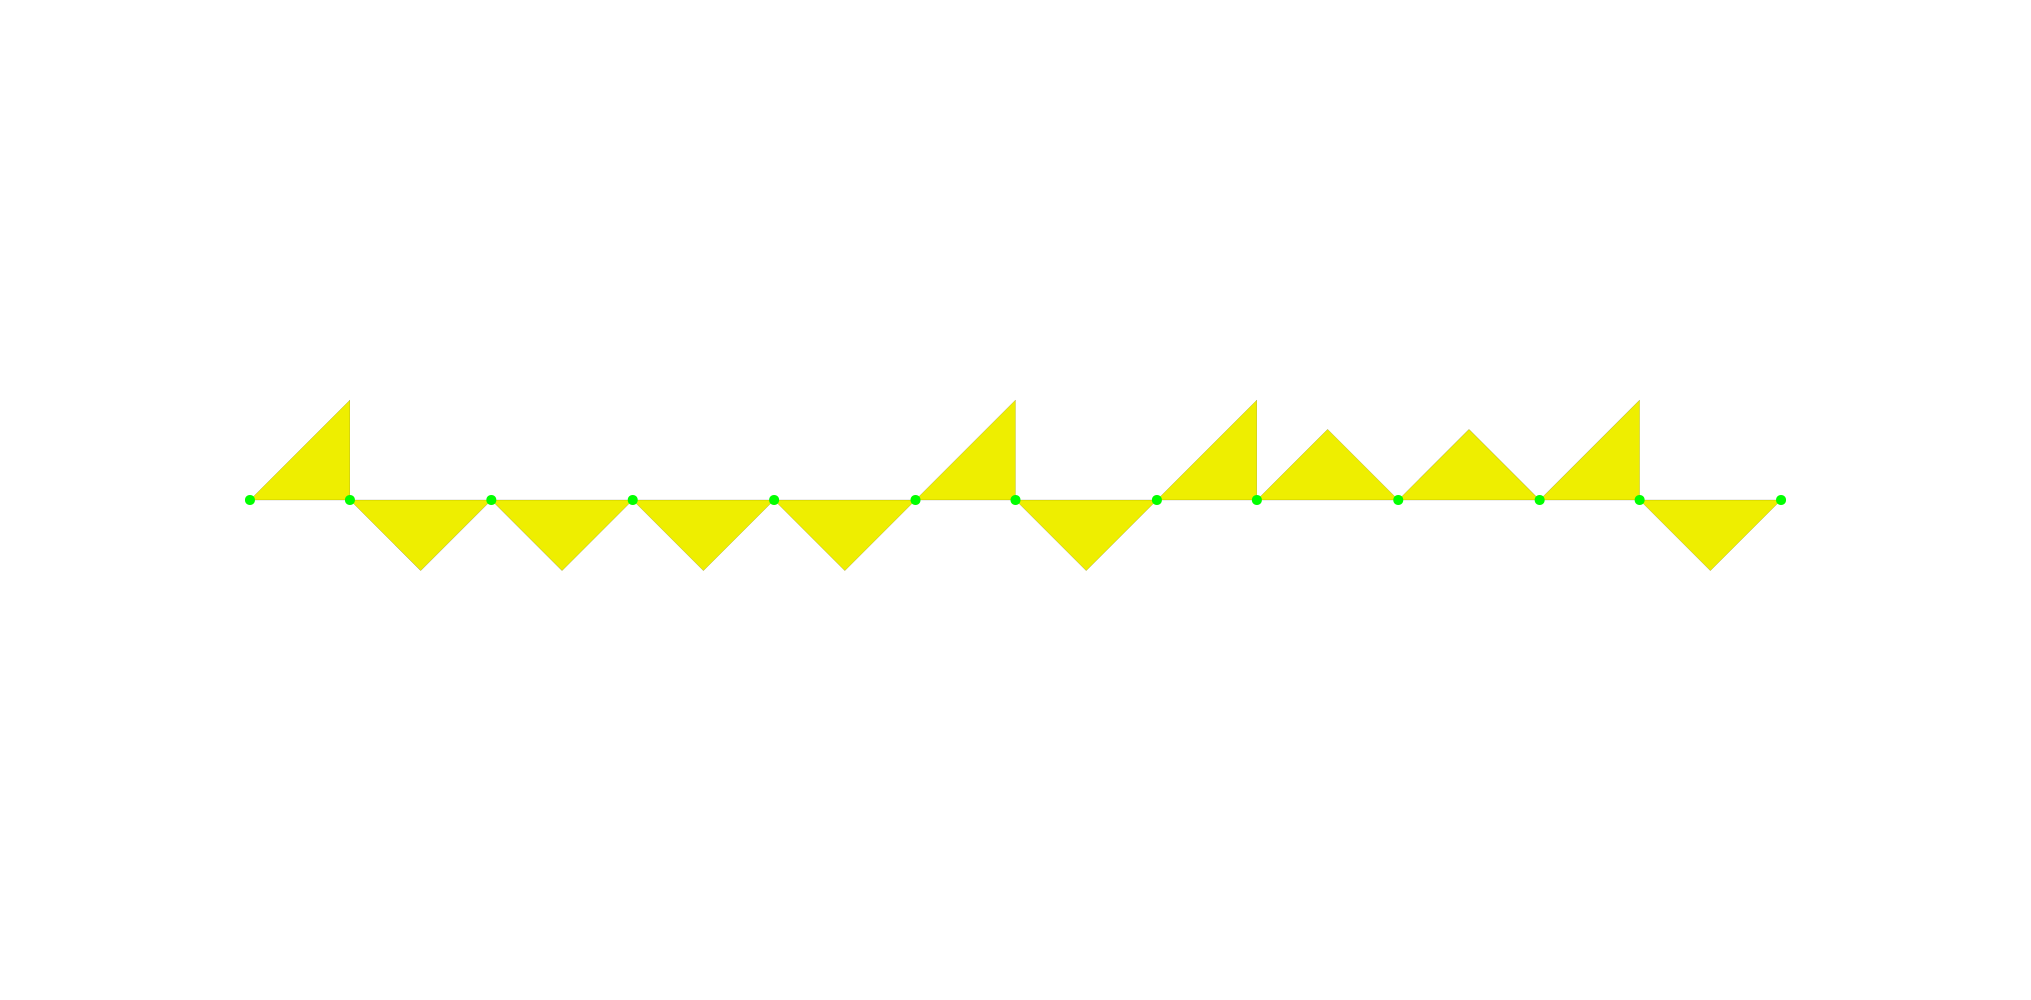

In [110]:
polygons, offsets = get_polygons_and_offsets()

drawing = draw_vertex_unfolding(polygons, offsets)
drawing